**Градиентный спуск** применяется для линейной регрессии для нахождения весов вместо МНК, так как в классическом случае происходит умножение и обращение матриц. Перемножать матрицы в принципе трудоемкий процесс (для тех, что с тысячами, а то и с миллионами элементов, ваще жесть), а обратить вообще можно не каждую матрицу. Поэтому используется ГС - численное решение, позволяющее найти локальный минимум функции (нужно для минимизации функции потерь). Кстати, как я понял, именно этот метод используется в L1-регуляризации.

Итак:

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import random
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 1

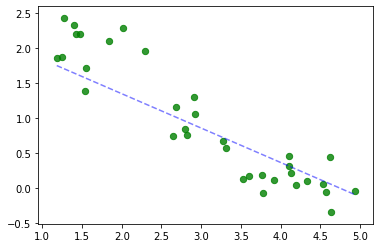

In [2]:
def gradient(X, y, w, alpha):
    n = X.shape[0]
    y_hat = X.dot(w.T)
    error = y - y_hat
    
#     вот тут у нас и регуляризация - по L2-регрессии: мы берем квадрат нормы и дифференцируем его по весу, получается
#     выражение 2*alpha*w, где alpha - гиперпараметр градиентного спуска
    D = np.multiply(X, error).sum(axis=0)*(-2) / n + 2 * alpha * w
    return D, error

def eval_w_next(X, y, alpha, w_current):
    D, error = gradient(X, y, w_current, alpha)
    w_next = w_current - alpha * D
    w_difference = distance.euclidean(w_current, w_next)
    return (w_next, w_difference, D)

def gradient_descent(X, y, alpha=0.008, eps=0.001):
    m = X.shape[1]
    w = np.random.random(m).reshape(1, -1)
    w_next, w_difference, D = eval_w_next(X, y, alpha, w)
    step = 0
    while w_difference > eps:
        w = w_next
        w_next, w_difference, D = eval_w_next(X, y, alpha, w)
        step += 1
    return w

df = pd.read_csv("non_linear.csv")        
df = df[(df.x_train > 1) & (df.x_train < 5)].copy()

X = df['x_train'].values.reshape(-1, 1)
n = X.shape[0]
m = X.shape[1]
X = np.hstack([np.ones(n).reshape(-1, 1), X])
y = df["y_train"].values.reshape(-1, 1)

w = gradient_descent(X, df["y_train"].values.reshape(-1, 1), alpha=0.008)

X = df["x_train"].values.reshape(-1, 1)
y_pred = np.hstack([np.ones(X.size).reshape(-1, 1), X]).dot(w.T)

# строим график
plt.plot(X, y_pred, 'b--', alpha=0.5, label='manifold')
plt.scatter(df['x_train'], df['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

### 2

In [30]:
df = pd.read_csv("non_linear.csv")
X = df['x_train'].values.reshape(-1, 1)
y = df["y_train"].values.reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
poly = PolynomialFeatures(degree=8)  # например, 8-я степень
X_poly = poly.fit_transform(X_train)
X_valid = poly.fit_transform(X_valid)

model_Ridge = Ridge(alpha=0.8).fit(X_poly, y_train)
y_pred_Ridge = model_Ridge.predict(X_valid)

model_Lasso = Lasso(alpha=0.8).fit(X_poly, y_train)
y_pred_Lasso = model_Lasso.predict(X_valid)

w_Ridge = model_Ridge.coef_
w_Lasso = model_Lasso.coef_
print(w_Ridge, w_Lasso)

[[ 0.00000000e+00  4.54261785e-01  3.41976832e-01  3.27582096e-02
  -2.07134533e-01  3.63216319e-02  1.18194117e-02 -3.68031933e-03
   2.63585522e-04]] [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.08299601e-02
 -9.52247249e-03  1.03490179e-03  1.87872250e-04  3.38785318e-06
 -2.14838285e-06]


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7134369621139713, tolerance: 0.0024481555784964045
  positive)


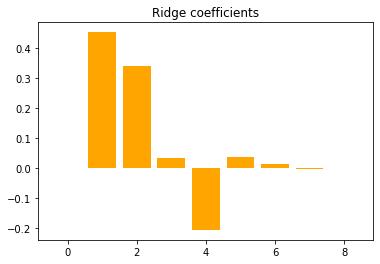

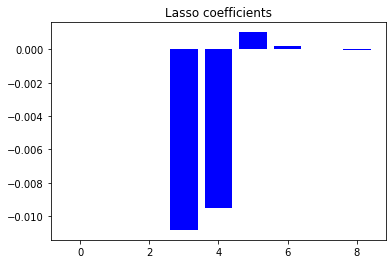

In [31]:
plt.bar(range(9), w_Ridge[0], color='orange')
plt.title("Ridge coefficients")
plt.show()

plt.bar(range(9), w_Lasso, color='blue')
plt.title("Lasso coefficients")
plt.show()

Как видим, лассо-регрессия обнулила некоторые коэффициенты, остальные также принимают крайне малые значения, в то время как в L2-регуляризации значимы все веса.

48


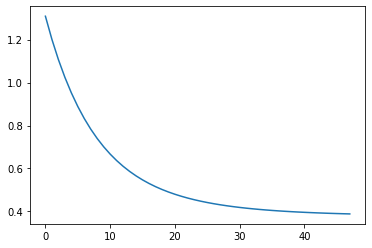

In [53]:
df = pd.read_csv("non_linear.csv")
X = df['x_train'].values.reshape(-1, 1)
y = df["y_train"]
df = df[(df.x_train > 1) & (df.x_train < 5)].copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

model = SGDRegressor(learning_rate="constant", eta0=0.009, fit_intercept=True, random_state=42)
w_current = np.random.random(2)
eps = 0.001
w_diff = []
mse = []

for step in range(800):
    model = model.partial_fit(X_train, y_train)
    w_diff.append(distance.euclidean(w_current, model.coef_))
    if w_diff[-1] < eps:
        print(step)
        break
    mse.append(mean_squared_error(y_valid, model.predict(X_valid)))
    w_current = model.coef_.copy()

plt.plot(range(step), mse)
plt.show()

### 3

937


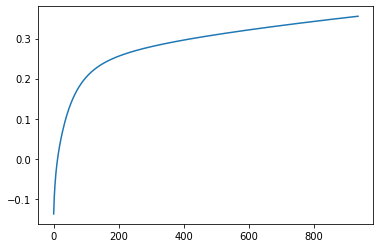

0.35577370630426874

In [29]:
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

boston_dataset = load_boston()
X = boston_dataset.data
y = boston_dataset.target
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

model = SGDRegressor(learning_rate="constant", eta0=0.000001, fit_intercept=True, random_state=42)
w_current = np.random.random(X.shape[1])
eps = 0.001
w_diff = []
r2 = None
r2 = []

for step in range(1000):
    model = model.partial_fit(X_train, y_train)
    w_diff.append(distance.euclidean(w_current, model.coef_))
    if w_diff[-1] < eps:
        print(step)
        break
    r2.append(r2_score(y_valid, model.predict(X_valid)))
    w_current = model.coef_.copy()

if step == 999:
    step = range(step+1)
else:
    step = range(step)
    
plt.plot(step, r2)
plt.show()
r2[-1]

Как видим, при крайне малом шаге коэффициент детерминации все равно достаточно невелик.